In [1]:
library(tidyverse)
library(nortest)
library(pgirmess)
library(ggplot2)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# 1 Introdución
El **análisis de varianza** (ANOVA) constituye la herramienta básica para el estudio del efecto de uno o más factores (cada uno con dos o más niveles) sobre la media de una variable continua.

**Se usa cuando se desea comparar las medias de dos o más grupos**

Este **análisis de varianza**, toma en cuenta la varianza entre los grupos, y la varianza dentro de los grupos.

- La varianza entre los grupos se calcula comparando la media total de cada grupo con la media global de los datos.
- La varianza dentro de cada grupo es la variación de cada observación con respecto a la media del grupo. Se calcula la suma de cuadrados SS para cada uno.

Hay diferentes tipos de _ANOVA_, todo depende:

- si son datos independientes (es ANOVA entre sujetos),
- si son datos pareados (es ANOVA de mediciones repetidas),
- si se comparan una variable cuantitativa dependiente contra los niveles de una única variable explicativa o factor (ANOVA de una vía) o ante dos factores (ANOVA de dos vías).

# 2 One-way ANOVA (ANOVA de una vía)
Analiza si los valores de una variable (dependiente) están fuertemente influenciados por los valores de otra variable (independiente). Usualmente una variable clasificadora o de agrupación.

Se emplea cuando los datos no están pareados y se quiere determinar si existen diferencias significativas entre las medias de una variable aleatoria continua en los diferentes niveles de la otra variable cualitativa o factor.

La variable dependiente (de respuesta) tiene que ser paramétrica, la variable independiente casi nunca lo es.

Ejemplos:

- Evaluación del efecto de 4 distintos tipos de sustrato en el crecimiento de plantas de café.
- Evaluación del impacto de 5 distintos programas de ejercicio en el crecimiento de masa muscular.

## 2.1 Supuestos

1. La variable de respuesta debe ser cuantitativa.
2. Independencia de las observaciones. Muestra menor del 10% de la población. Y grupos independientes.
3. Distribución normal de cada uno de los grupos: dist normal dentro del grupo, menos estricto entre más grande es el grupo.
4. Varianza constante entre grupos (homocedasticidad).

**Modelo**

$H_0$: todas las medias de los grupos son iguales. No hay diferencias entre los grupos $\mu_1=\mu_2=\dots=\mu_k$$

$H_1$: al menos un par de medias son significativamente distintas una de la otra.

Con nivel de significancia $\alpha = 0.05$

> El estadístico estudiado en el ANOVA, conocido como $F_{ratio}$. Este estadístico sigue una distribución conocida como "F de Fisher-Snedecor". Si se cumple la hipótesis nula $H_0$, el estadístico $F$ adquiere el valor de $1$ ya que la intervarianza será igual a la intravarianza. Cuanto más difieran las medias de los grupos mayor será la varianza entre medias en comparación al promedio de la varianza dentro de los grupos, obteniéndose valores de $F$ superiores a $1$.

**Trabajemos con los datos de tráfico**

Explorar los datos y hacer las transformaciones requeridas, para luego trabajar sobre los supuestos.

In [2]:
# archivo de estadisticas de trafico
trafico <- read.csv("Data/trafico.csv") 
trafico$CLASS <- as.factor(trafico$CLASS)

# estudio de datos
table(trafico$CLASS)


 1  2  3  4 
 8 56 18 39 

In [3]:
trafico %>% split(.$CLASS) %>% map(summary)

$`1`
       X              AADT           CTYPOP           LANES          WIDTH     
 Min.   :21.00   Min.   : 5697   Min.   : 25717   Min.   :4.00   Min.   :24.0  
 1st Qu.:32.00   1st Qu.:12562   1st Qu.: 34829   1st Qu.:4.00   1st Qu.:24.0  
 Median :36.00   Median :17688   Median : 41293   Median :4.00   Median :24.0  
 Mean   :41.38   Mean   :18593   Mean   : 56922   Mean   :4.25   Mean   :25.5  
 3rd Qu.:45.00   3rd Qu.:21008   3rd Qu.: 71051   3rd Qu.:4.00   3rd Qu.:24.0  
 Max.   :78.00   Max.   :40642   Max.   :113571   Max.   :6.00   Max.   :36.0  
    CONTROL  CLASS     TRUCK       LOCALE 
 Min.   :1   1:8   Min.   :1   Min.   :1  
 1st Qu.:1   2:0   1st Qu.:1   1st Qu.:1  
 Median :1   3:0   Median :1   Median :1  
 Mean   :1   4:0   Mean   :1   Mean   :1  
 3rd Qu.:1         3rd Qu.:1   3rd Qu.:1  
 Max.   :1         Max.   :1   Max.   :1  

$`2`
       X               AADT             CTYPOP           LANES      
 Min.   :  1.00   Min.   :  201.0   Min.   :  7716   Min.  

In [4]:
aggregate(AADT ~ CLASS, data = trafico, FUN = mean)

CLASS AADT     
1 1     18593.125
2 2      3464.554
3 3     74310.000
4 4     17221.026

In [5]:
aggregate(AADT ~ CLASS, data = trafico, FUN = sd)

CLASS AADT     
1 1     10384.748
2 2      4036.491
3 3     42846.847
4 4     14665.216

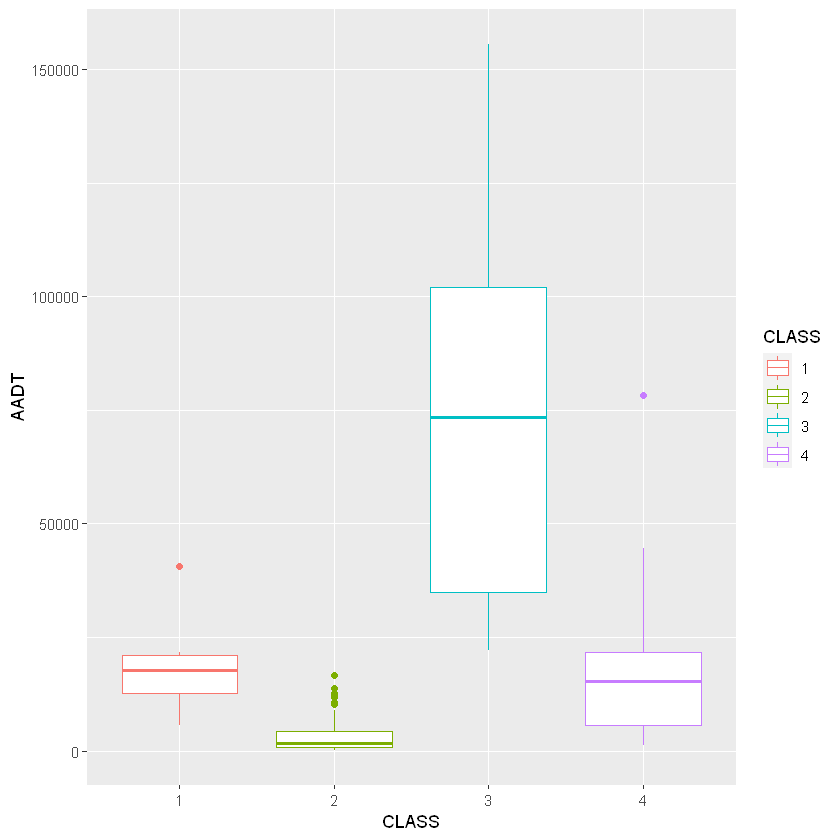

In [6]:
# Verificar visualmente si los promedios de tráfico anual promedio(AADT) son diferentes por cada tipo de carretera (CLASS)
# graficar cajas y bigotes para comparar valores
ggplot(data = trafico, aes(x=AADT, y=CLASS, color = CLASS)) + geom_boxplot() + coord_flip()

In [7]:
# transformación logaritmica de la variabel AADT
trafico$logAADT <-  log(trafico$A)

### Normalidad y homocedasticidad
> NOTA: El test Lilliefors asume que la media y varianza son desconocidas, estando especialmente desarrollado para contrastar la normalidad. Es la alternativa al test de Shapiro-Wilk cuando el número de observaciones es mayor de 50.

In [8]:
#Calcular supuesto de normalidad por grupo

# Visualicemos clase 4
g2 <- trafico[trafico$CLASS == 4,]
ggplot(g2, aes(sample = logAADT)) + stat_qq() + stat_qq_line()

In [9]:
# > 50 Lilliefors
# < 50 Shapiro

lillie.test(trafico[trafico$CLASS == 1,]$AADT)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  trafico[trafico$CLASS == 1, ]$AADT
D = 0.26174, p-value = 0.1095


In [10]:
lillie.test(trafico[trafico$CLASS == 1,]$logAADT)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  trafico[trafico$CLASS == 1, ]$logAADT
D = 0.18445, p-value = 0.5854


In [11]:
#probar normalidad de los grupos
by(data = trafico, INDICES = trafico$CLASS, FUN = function(x){ lillie.test(x$logAADT)})

trafico$CLASS: 1

	Lilliefors (Kolmogorov-Smirnov) normality test

data:  x$logAADT
D = 0.18445, p-value = 0.5854

------------------------------------------------------------ 
trafico$CLASS: 2

	Lilliefors (Kolmogorov-Smirnov) normality test

data:  x$logAADT
D = 0.10262, p-value = 0.15

------------------------------------------------------------ 
trafico$CLASS: 3

	Lilliefors (Kolmogorov-Smirnov) normality test

data:  x$logAADT
D = 0.1904, p-value = 0.08363

------------------------------------------------------------ 
trafico$CLASS: 4

	Lilliefors (Kolmogorov-Smirnov) normality test

data:  x$logAADT
D = 0.1641, p-value = 0.009707


In [12]:
# Homocedasticidad
require(car)

Loading required package: car

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




In [13]:
leveneTest(logAADT ~ CLASS, trafico, center = "median")

Df  F value  Pr(>F)    
group   3 2.454903 0.06659913
      117       NA         NA

In [14]:
# Como resultado no hay evidencias significativas de falta de homocedasticidad

Si no se puede aceptar la homocedasticidad, se recurre a lo que se conoce como ANOVA heterodástica que emplea la corrección de Welch (Welch test), en R su función es ```oneway.test()```

### Calculo del ANOVA
La forma más adecuada de comprobar que se satisfacen las condiciones necesarias es estudiando los residuos del modelo una vez generado el ANOVA.

In [15]:
#correr el modelo con analisis de varianza
mod1 <- aov(logAADT~CLASS, data = trafico)
summary(mod1)

             Df Sum Sq Mean Sq F value Pr(>F)    
CLASS         3  196.8   65.61   72.17 <2e-16 ***
Residuals   117  106.4    0.91                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

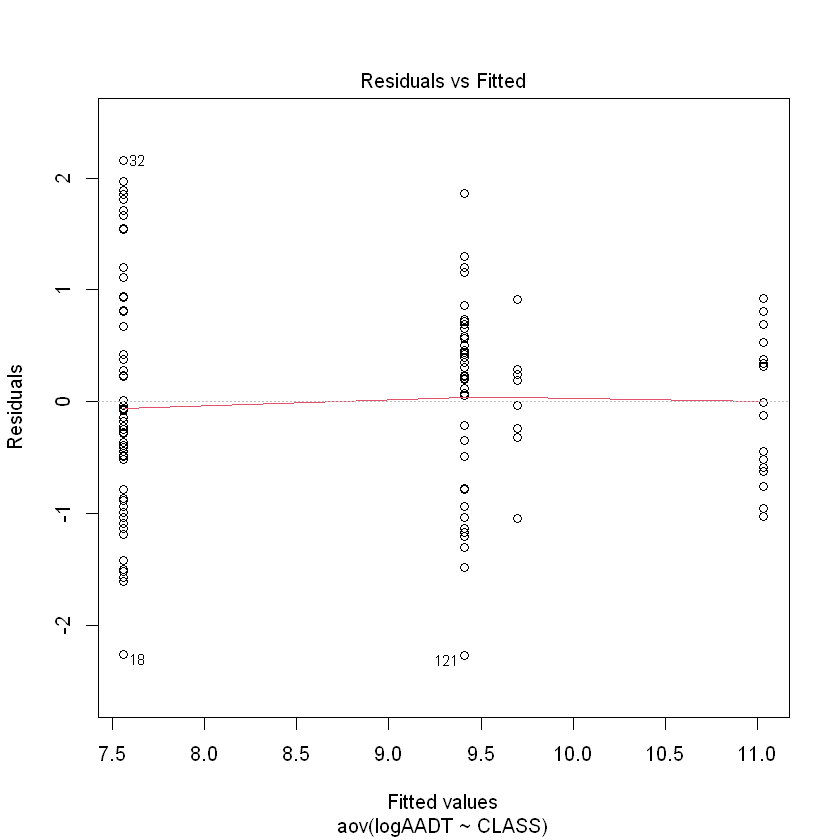

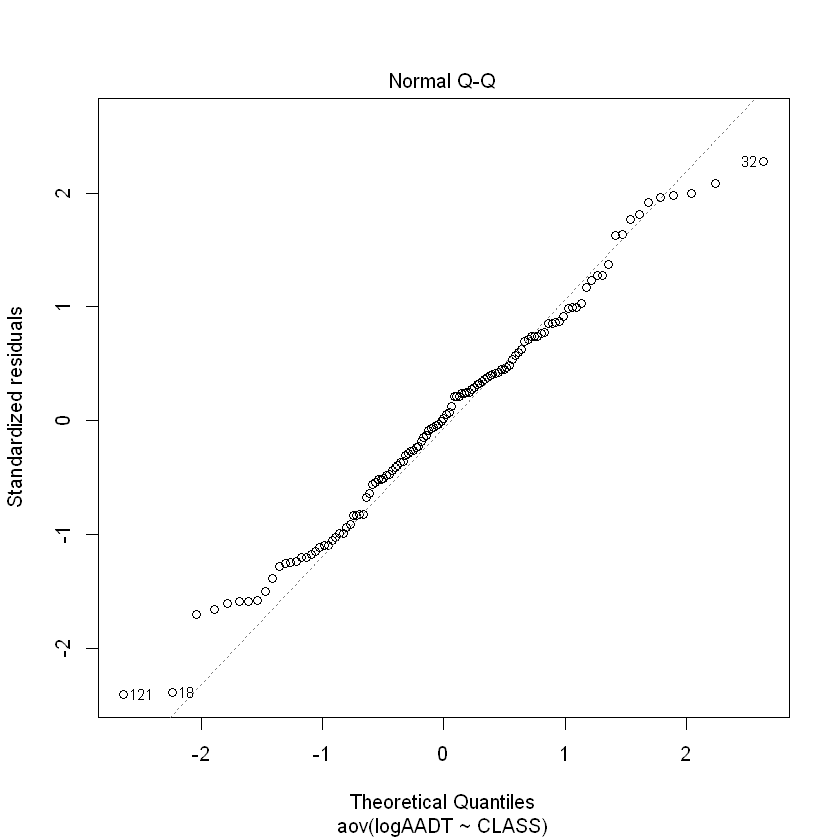

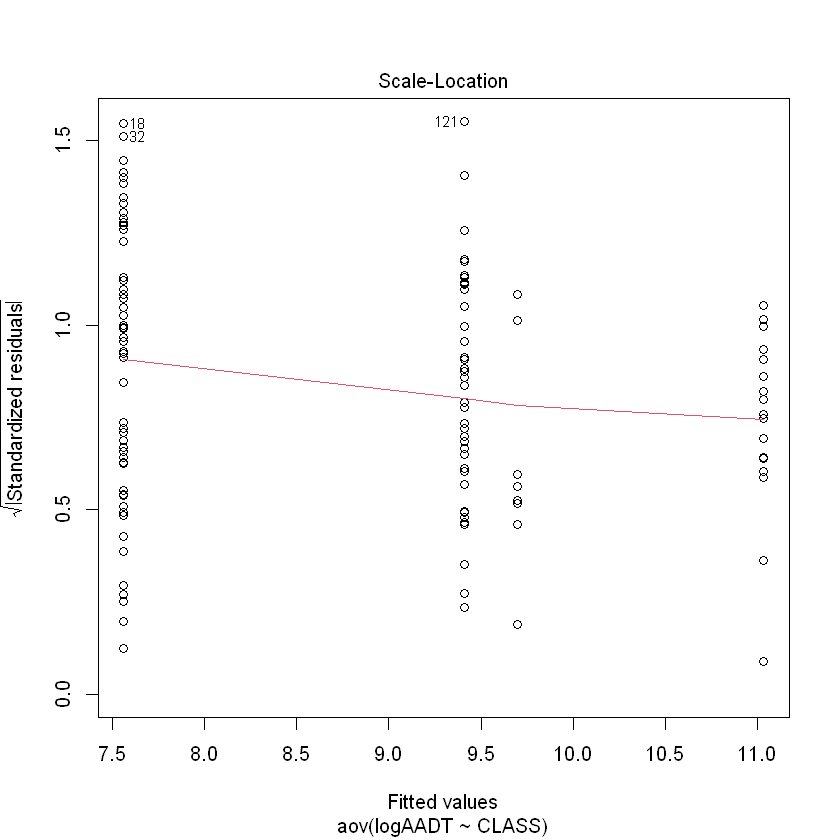

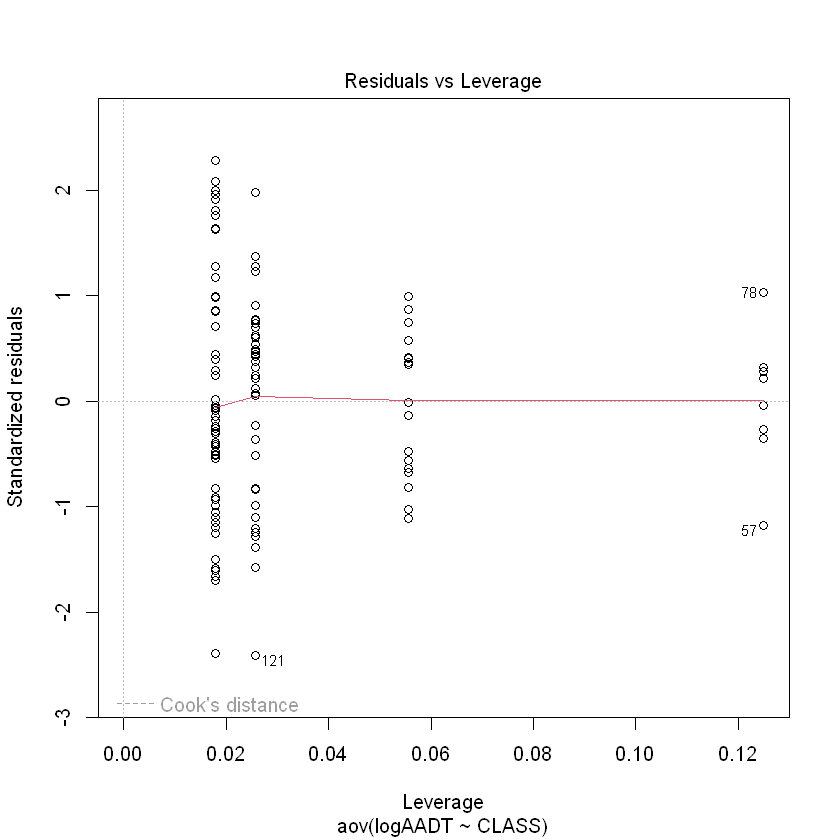

In [16]:
#Correr el plot para verificar residuos y qqnorm
plot(mod1)

In [17]:
#correr el modelo de regresion lineal
mod2 <- lm(logAADT~CLASS, data = trafico)
anova(mod2)

Df  Sum Sq   Mean Sq    F value  Pr(>F)      
CLASS       3 196.8388 65.6129367 72.17413 1.710058e-26
Residuals 117 106.3638  0.9090922       NA           NA

El p-value para la prueba está dado por $Pr(>F)$ que en este caso tiene un valor de $2e-16$, es decir se rechaza la hipótesis nula: se puede decir con mucha confianza que el AADT es claramente distinto por tipo de carreta, en al menos dos carreteras.

La representación gráfica de los residuos no muestra falta de homocedasticidad (gráfico 1) y en el qqplot los residuos se distribuyen muy cercanos a la línea de la normal (gráfico 2)

### Comparaciones múltiples de medias. Constrastes POST-HOC
Si un Análisis de Varianza resulta significativo, únicamente indica si existe afectación, indicando que al menos dos de las medias comparadas son significativamente distintas entre sí. Sin embargo no provee información acerca cuáles medias tienen afectación.

Para identificarlas hay que comparar dos a dos las medias de todos los grupos introducidos en el análisis mediante un t-test u otro test que compare 2 grupos, ha esto se le conoce como análisis **post-hoc**

Se puede o no realizar una corrección de los niveles de significancía, que se debe estudiar en cada caso. (Esto queda fuera del alcance del taller)

Los principales métodos de comparación post-hoc (algunas con corrección y otros no) son:

- Intervalos LSD de Fisher (Least Significance Method)
- Holm–Bonferroni Adjustment
- Tukey-Kramer Honest Significant Difference (HSD)
- Dunnett’s correction (Dunnett’s test)

Para describir la afectación se puede usar la prueba de **Tukey-Kramer** la cuál calcula la diferencia de impacto de cada valor en la variable independiente.

In [18]:
Tk <- TukeyHSD(mod1, "CLASS")
Tk

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = logAADT ~ CLASS, data = trafico)

$CLASS
          diff        lwr        upr     p adj
2-1 -2.1347497 -3.0740100 -1.1954893 0.0000002
3-1  1.3399743  0.2840314  2.3959173 0.0067722
4-1 -0.2858335 -1.2503434  0.6786763 0.8667698
3-2  3.4747240  2.8014054  4.1480426 0.0000000
4-2  1.8489161  1.3306289  2.3672034 0.0000000
4-3 -1.6258079 -2.3339230 -0.9176927 0.0000001


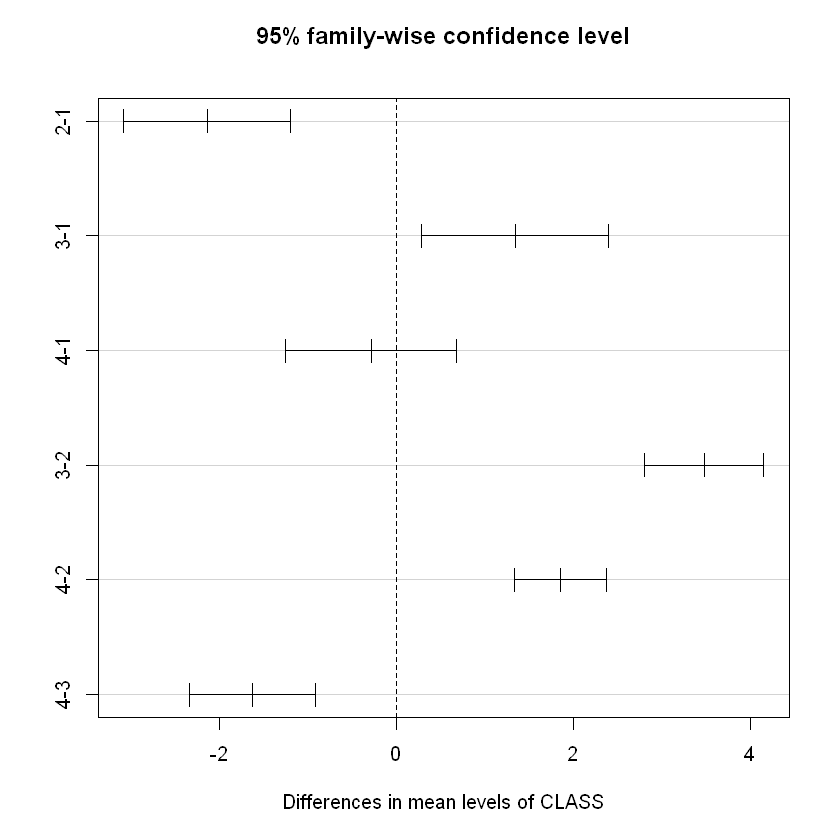

In [19]:
plot(Tk)

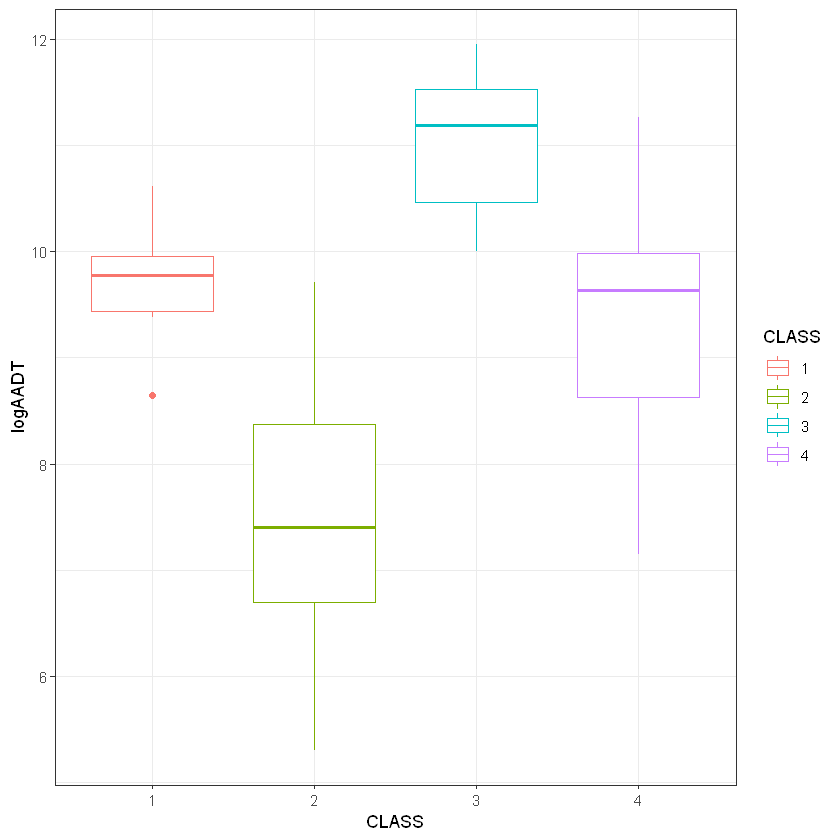

In [20]:
ggplot(data = trafico, aes(x = CLASS, y = logAADT, color = CLASS)) + geom_boxplot() + theme_bw()

## 2.2 Ejercicio
Supóngase que en un estudio se quiere comprobar si existe una diferencia significativa entre el porcentaje de bateos exitosos de los jugadores de béisbol dependiendo de la posición en la que juegan. En caso de que exista diferencia se quiere saber qué posiciones difieren del resto. Utilice los datos de **bateoAnova.csv** para desarrollar el problema.

In [21]:
d<-read_csv("Data/bateoAnova.csv")

New names:
• `` -> `...1`
Rows: 327 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): posicion
dbl (2): ...1, bateo

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [22]:
head(d)

...1 posicion bateo
1 1    OF       0.359
2 2    IF       0.340
3 3    IF       0.330
4 4    OF       0.341
5 5    IF       0.366
6 6    IF       0.333

In [23]:
d$posicion <- factor(d$posicion,levels=unique(d$posicion))

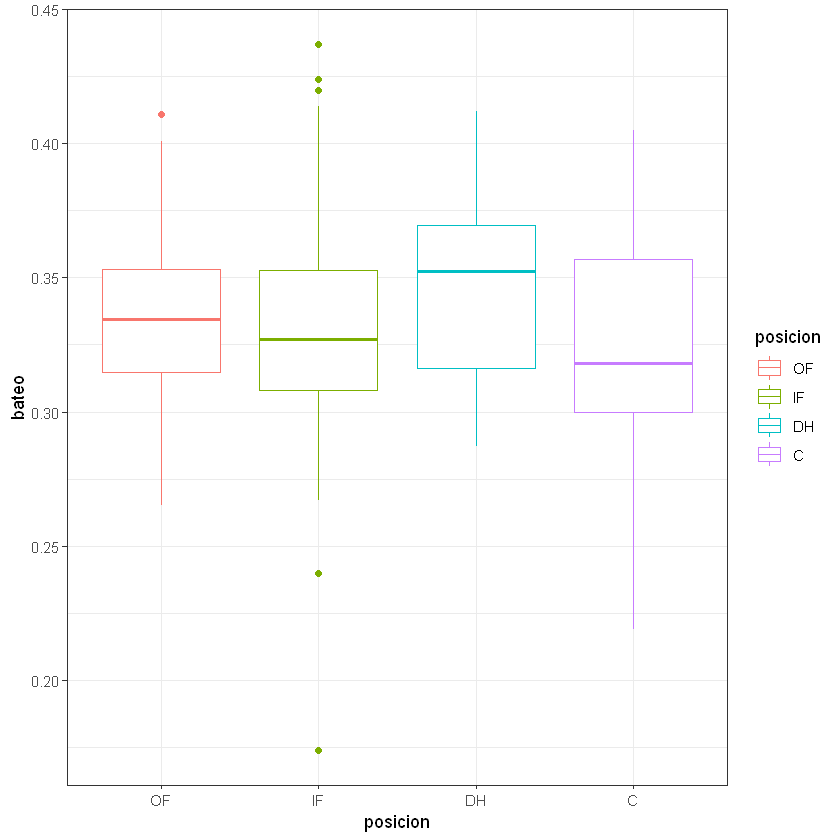

In [24]:
ggplot(data = d, aes(x = posicion, y = bateo, color = posicion)) + geom_boxplot() + theme_bw()

In [25]:
#correr el modelo con analisis de varianza
mod1 <- aov(bateo~posicion, data = d)
summary(mod1)

             Df Sum Sq  Mean Sq F value Pr(>F)
posicion      3 0.0076 0.002519   1.994  0.115
Residuals   323 0.4080 0.001263               

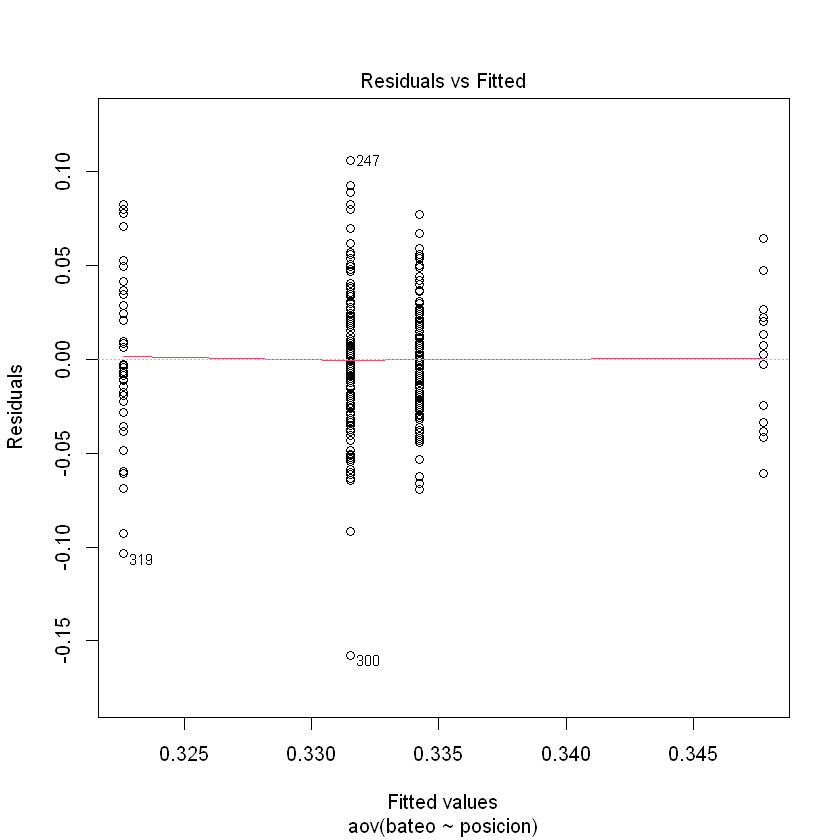

In [26]:
plot(mod1)

In [27]:
#correr el modelo de regresion lineal
mod2 <- lm(bateo~posicion, data = d)
anova(mod2)

Df  Sum Sq      Mean Sq     F value  Pr(>F)   
posicion    3 0.007557247 0.002519082 1.994349 0.1146928
Residuals 323 0.407984484 0.001263110       NA        NA

# 3 Multi-way ANOVA (Anova de dos vías)
Si se cree que la variable **dependiente** está definida, no por una, sino por múltiples variables **independientes** interactuando juntas, se puede componer la prueba de ANOVA.

**Modelo aditivo**: + Permite estudiar la influencia de los factores en la variable de respuesta, cada uno por separado.

**Modelo con interacción**: * La interacción estudie si la influencia de uno de los factores varía dependiendo de los niveles de otro factor.

> El efecto de la interacción doble consiste en estudiar si la influencia de uno de los factores varía dependiendo de los niveles del otro factor.

**Hipótesis**: El ANOVA de dos vías con repeticiones combina 3 hipótesis nulas,

$H_0$: Las medias de las observaciones agrupadas por un factor son iguales, Las medias de las observaciones agrupadas por el otro factor son iguales, No hay interacción entre los dos factores.

$H_1$: Separadamente, cada sentencia en $H_0$ es incorrecto

In [28]:
#medias de grupos
traf.means <- aggregate(trafico$logAADT, by=list(trafico$CLASS,trafico$CTYPOP),FUN=mean)

# Anova con una variables diferente
modLanes <- lm(logAADT ~ CTYPOP, trafico)
summary(modLanes)


Call:
lm(formula = logAADT ~ CTYPOP, data = trafico)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1432 -0.9765  0.0604  1.1117  2.3436 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 8.055e+00  1.492e-01  54.006  < 2e-16 ***
CTYPOP      2.885e-06  3.545e-07   8.139 4.42e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.279 on 119 degrees of freedom
Multiple R-squared:  0.3576,	Adjusted R-squared:  0.3522 
F-statistic: 66.24 on 1 and 119 DF,  p-value: 4.42e-13


In [29]:
#Anova aditivo con varias variables
mod1 <- lm(logAADT ~ CLASS+CTYPOP, trafico)
summary(mod1)


Call:
lm(formula = logAADT ~ CLASS + CTYPOP, data = trafico)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.16667 -0.52919 -0.03455  0.52878  2.14572 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.623e+00  3.165e-01  30.407  < 2e-16 ***
CLASS2      -2.172e+00  3.379e-01  -6.427 3.00e-09 ***
CLASS3       6.781e-01  4.120e-01   1.646   0.1025    
CLASS4      -7.524e-01  3.647e-01  -2.063   0.0413 *  
CTYPOP       1.288e-06  3.108e-07   4.144 6.52e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8937 on 116 degrees of freedom
Multiple R-squared:  0.6944,	Adjusted R-squared:  0.6839 
F-statistic:  65.9 on 4 and 116 DF,  p-value: < 2.2e-16


In [30]:
anova(mod1)

Df  Sum Sq    Mean Sq   F value  Pr(>F)      
CLASS       3 196.83881 65.612937 82.14956 1.436111e-28
CTYPOP      1  13.71447 13.714474 17.17097 6.521041e-05
Residuals 116  92.64932  0.798701       NA           NA

In [31]:
#Anova con interacción
modInter <- lm(logAADT ~ CLASS*CTYPOP, trafico)
summary(modInter)


Call:
lm(formula = logAADT ~ CLASS * CTYPOP, data = trafico)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.18387 -0.53204 -0.01968  0.54880  2.14726 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    9.326e+00  6.434e-01  14.497  < 2e-16 ***
CLASS2        -1.855e+00  6.573e-01  -2.822  0.00564 ** 
CLASS3         8.663e-01  7.642e-01   1.134  0.25935    
CLASS4        -4.532e-01  6.836e-01  -0.663  0.50876    
CTYPOP         6.492e-06  9.811e-06   0.662  0.50953    
CLASS2:CTYPOP -5.446e-06  9.835e-06  -0.554  0.58084    
CLASS3:CTYPOP -5.015e-06  9.830e-06  -0.510  0.61097    
CLASS4:CTYPOP -5.211e-06  9.820e-06  -0.531  0.59672    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9035 on 113 degrees of freedom
Multiple R-squared:  0.6958,	Adjusted R-squared:  0.6769 
F-statistic: 36.92 on 7 and 113 DF,  p-value: < 2.2e-16


In [32]:
anova(modInter)

Df  Sum Sq      Mean Sq    F value    Pr(>F)      
CLASS          3 196.8388102 65.6129367 80.3781266 6.615832e-28
CTYPOP         1  13.7144740 13.7144740 16.8007070 7.846789e-05
CLASS:CTYPOP   3   0.4070343  0.1356781  0.1662104 9.189514e-01
Residuals    113  92.2422823  0.8163034         NA           NA

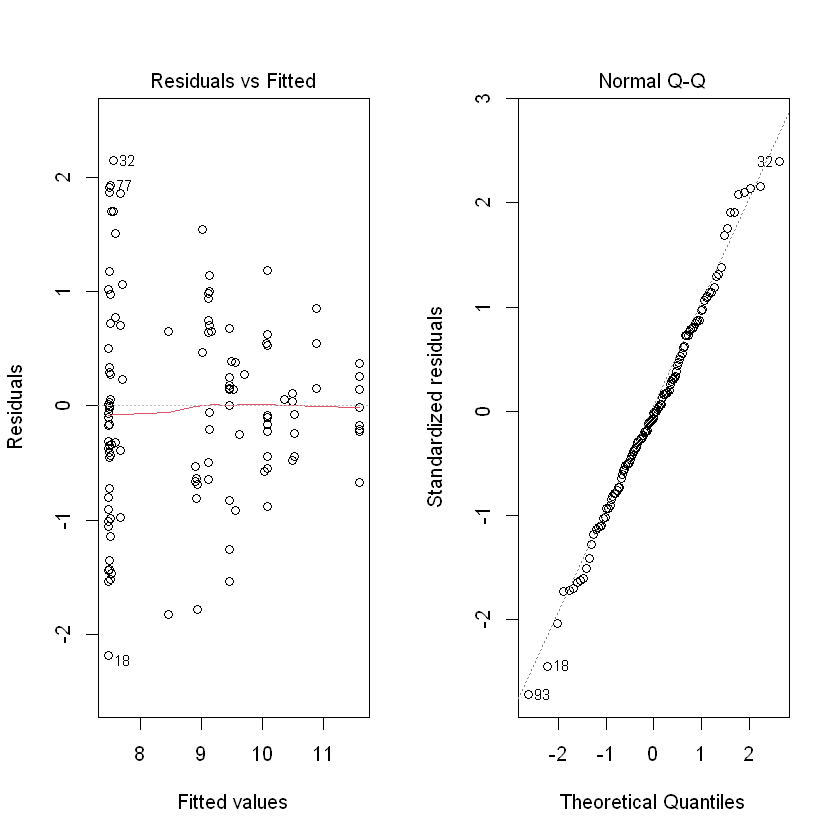

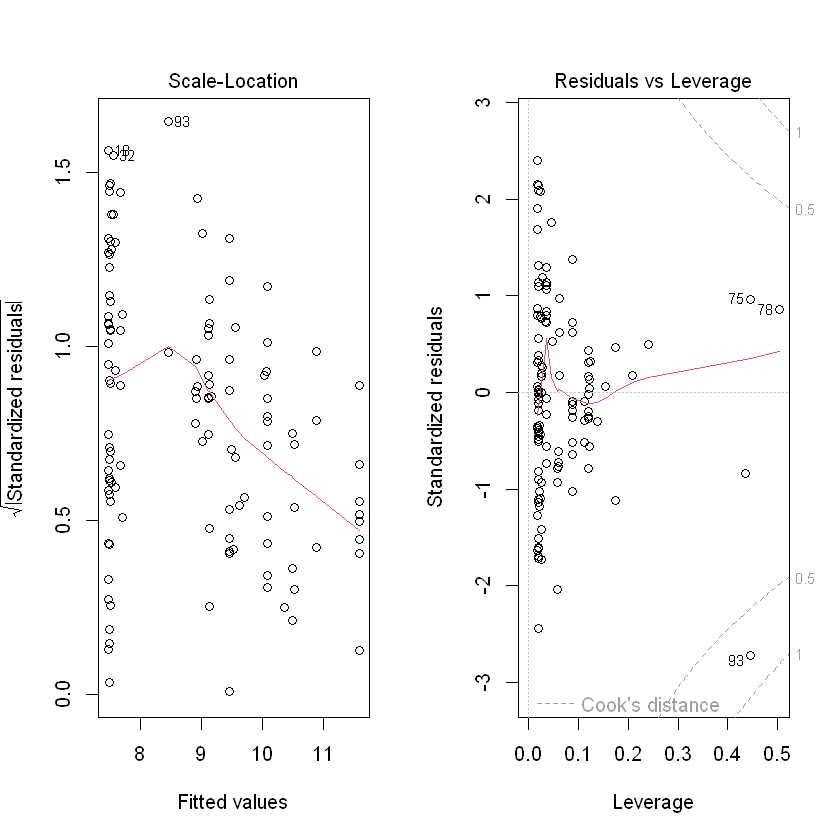

In [33]:
#Gráfico de anova, verificar residuos y qqnorm
par(mfrow = c(1,2))
plot(modInter)

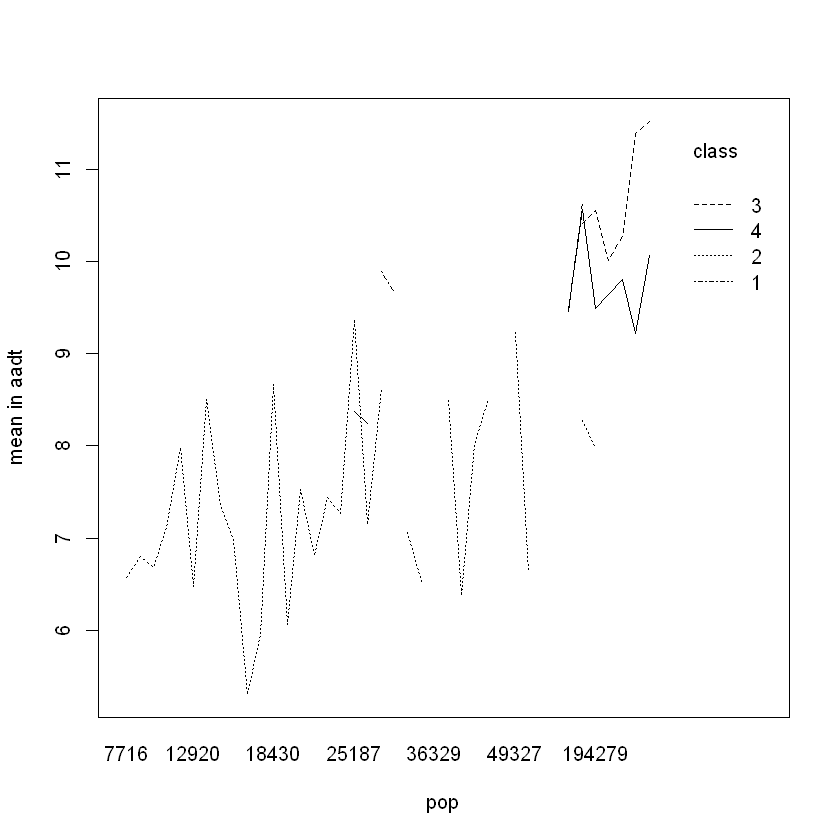

In [34]:
#Gráfico de interacción
interaction.plot(x.factor=traf.means[,2],trace.factor=traf.means[,1],
                 response=traf.means$x,trace.label="class",
                 xlab="pop",ylab="mean in aadt")

# 4 Prueba de Kruskal-Wallis
Es una alternativa **no paramétrica** a one-way ANOVA. Requiere que las distribuciones de las muestras sean similares así como sus varianzas (cercano a homocedasticidad). Puede ser aplicada a one-way data con más de dos grupos.

Este test no paramétrico prueba se puede utilizar cuando existe cierta falta de normalidad, si la simetría es muy pronunciada y el tamaño de cada grupo no es muy grande.

Hipótesis:

- $H_0$ : las medianas de los grupos con iguales
- $H_A$ : al menos una mediana es diferente
El resultado indica si hay una diferencia entre los grupos, pero no dice cuál de los grupos en diferentes a los demás.

In [35]:
#La variable Home Runs (HR) no tiene distribución normal
kruskal.test(log(AADT) ~ CLASS, trafico)


	Kruskal-Wallis rank sum test

data:  log(AADT) by CLASS
Kruskal-Wallis chi-squared = 80.069, df = 3, p-value < 2.2e-16


Esta prueba evalúa las **medianas** en lugar de los **promedios** ($H_0$ mediana en las muestras no es significativamente distinta). En caso de que las distribuciones sean distintas, existe una alternativa llamada **Welch ANOVA**.

Un análisis de los resultados puede realizarse empleando un análogo al **Tukey** encontrado en el paquete *pgirmess*.

In [36]:
kruskalmc(trafico$AADT, trafico$CLASS, probs = 0.05)

Multiple comparison test after Kruskal-Wallis 
p.value: 0.05 
Comparisons
      obs.dif critical.dif difference
1-2 48.964286     34.97439       TRUE
1-3 28.250000     39.31919      FALSE
1-4  7.108974     35.91458      FALSE
2-3 77.214286     25.07175       TRUE
2-4 41.855311     19.29899       TRUE
3-4 35.358974     26.36744       TRUE

## 4.1 Ejemplo crecimiento de plantas

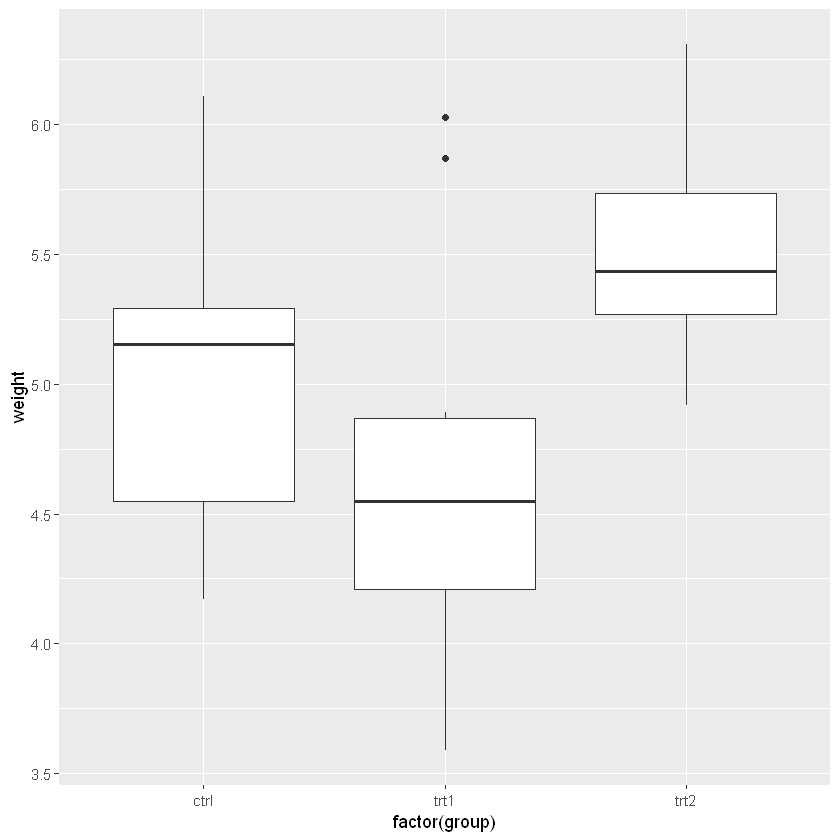

In [37]:
plants <- PlantGrowth # proviene de paquete datasets, library(datasets)

box_plot <- ggplot(data = plants, aes(x=factor(group), y=weight, group=group))+geom_boxplot()
box_plot

In [38]:
#Antes de correr las pruebas, revisar la normalidad de los datos

#Correr Kruskal Wallis Test
kruskal.test(weight ~ group, plants)


	Kruskal-Wallis rank sum test

data:  weight by group
Kruskal-Wallis chi-squared = 7.9882, df = 2, p-value = 0.01842


In [39]:
kruskalmc(plants$weight, plants$group)

Multiple comparison test after Kruskal-Wallis 
p.value: 0.05 
Comparisons
          obs.dif critical.dif difference
ctrl-trt1    4.40     9.425108      FALSE
ctrl-trt2    6.65     9.425108      FALSE
trt1-trt2   11.05     9.425108       TRUE

# 5 Material de referencia
- The Book of R: A First Course in Programming and Statistics. Tilman M. Davies. No Starch Press, 2016
- Intro to Mathematical Statistics. Hogg, McKean & Craig. Eighth Edition. 2019. https://minerva.it.manchester.ac.uk/~saralees/statbook2.pdf